In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_experimental langgraph langchain langchain_openai

In [3]:
import getpass
import os
def _set_if_undefined(var : str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [6]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [7]:
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

llm = ChatOpenAI(model="gpt-4o-mini")

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [8]:
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only perform research on the latest financial market data from the current year. "
        "Work with your colleague to generate investment advice."
        "You should not generate investment advice, leave that to your colleague."
    ),
)

In [9]:
def research_node(state: MessagesState) -> Command[Literal["investment_advisor", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "investment_advisor")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [10]:
investment_agent = create_react_agent(
    llm,
    tools=[],
    prompt=make_system_prompt(
        "You can only generate investment predictions and market advice based on the research data provided. "
        "Support your advice with quantitative metrics like stock price percent changes, key ratios, and other relevant data."
        "Collaborate with your researcher colleague to produce the final answer."
        "If the question is regarding investment the final answer should point to one direction: invest or do not invest."
    ),
)

In [11]:
def investment_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = investment_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="investment_advisor")
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("investment_advisor", investment_node)
workflow.add_edge(START, "researcher")
graph = workflow.compile()

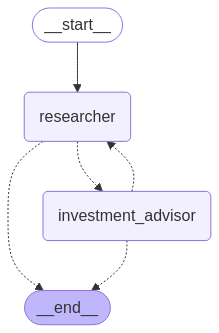

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [18]:
events = graph.stream(
    {
        "messages": [
            ("user", "How is the S&P 500 growth looking like for 2025?")
        ],
    },
    {"recursion_limit": 150},
)
data = None
for event in events:     
    data = event.get("investment_advisor") or event.get("researcher")
if data:
    print(data["messages"][-1].content)

FINAL ANSWER: The growth outlook for the S&P 500 in 2025 appears generally positive, with analysts predicting an earnings growth of approximately 11.1%. The index is expected to potentially finish the year up around 9% from its current levels. However, some strategists are reevaluating their forecasts considering potential economic changes, including flat corporate earnings. Given the positive growth expectations, it may be advisable to consider investing in the S&P 500.
